## Recommendations for Microsoft's New Movie Studio

####  In this notebook we are going to analyze the relationship between the movie success and movie time of release,movie runtime, movie genre, directors, and actors/actresses. Success will be based on ROI and Profit margin.

#### First objective is to clean up the movie budget dataframe, then merge all the relevant data sets.

In [1]:

#importing packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib.pyplot import figure
import sqlite3

In [2]:
ls

'#1 jbook stefano.ipynb'       im.db
 Andrew_Jbook_10_04_22.ipynb   jbook_Samuel.ipynb


In [3]:
#creating connection to the data
conn = sqlite3.connect('../zippedData/im.db')

In [4]:
#creating variable to read csv file
funds = pd.read_csv('../zippedData/tn.movie_budgets.csv.gz')

In [5]:
#examining structure of database
pd.read_sql("""

SELECT *

FROM sqlite_master

""", conn)

,type,name,tbl_name,rootpage,sql
0,table,movie_basics,movie_basics,2,"CREATE TABLE ""movie_basics"" (\n""movie_id"" TEXT..."
1,table,directors,directors,3,"CREATE TABLE ""directors"" (\n""movie_id"" TEXT,\n..."
2,table,known_for,known_for,4,"CREATE TABLE ""known_for"" (\n""person_id"" TEXT,\..."
3,table,movie_akas,movie_akas,5,"CREATE TABLE ""movie_akas"" (\n""movie_id"" TEXT,\..."
4,table,movie_ratings,movie_ratings,6,"CREATE TABLE ""movie_ratings"" (\n""movie_id"" TEX..."
5,table,persons,persons,7,"CREATE TABLE ""persons"" (\n""person_id"" TEXT,\n ..."
6,table,principals,principals,8,"CREATE TABLE ""principals"" (\n""movie_id"" TEXT,\..."
7,table,writers,writers,9,"CREATE TABLE ""writers"" (\n""movie_id"" TEXT,\n ..."


In [6]:
#creating finance calculations and formating numbers
numbers = funds.copy()



#funtion for cleaning
def clean_a_money_column(df, series_title):
    df[series_title] = df[series_title].str.replace('$','')
    df[series_title] = df[series_title].str.replace(',','')
    df[series_title] = pd.to_numeric(df[series_title])
    return df



#remove $ string
numbers = clean_a_money_column(numbers,'worldwide_gross')
numbers = clean_a_money_column(numbers,'domestic_gross')
numbers = clean_a_money_column(numbers,'production_budget')



# new column foreign_gross, Profit Margin, ROI
numbers['net_income'] = numbers['worldwide_gross'] - numbers['production_budget']
numbers['foreign_gross'] = numbers['worldwide_gross'] - numbers['domestic_gross']
numbers['Profit Margin'] = (numbers['net_income']*100)/numbers['worldwide_gross']
numbers.loc[numbers['Profit Margin'] == float('-inf'), 'Profit Margin'] = 0
numbers['ROI'] = (numbers['net_income']) / numbers['production_budget'] * 100


# new columns month and year 
numbers['Year'] = pd.to_numeric(numbers['release_date'].map(lambda x: x[-4:]))
numbers['Month'] = numbers['release_date'].map(lambda x: x[:3])



#check for dupes
movie_dupes = pd.Series(numbers['movie'].value_counts())
title_dupes = [movie_dupes.index[index] for index in list(range(len(movie_dupes))) if movie_dupes.values[index] > 1]
numbers[numbers['movie'].isin(title_dupes)]

numbers


,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,net_income,foreign_gross,Profit Margin,ROI,Year,Month
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,2351345279,2015837654,84.692106,553.257713,2009,Dec
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,635063875,804600000,60.733080,154.667286,2011,May
2,3,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350,-200237650,107000000,-133.703598,-57.210757,2019,Jun
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,1072413963,944008095,76.436443,324.384139,2015,May
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,999721747,696540365,75.925058,315.369636,2017,Dec
...,...,...,...,...,...,...,...,...,...,...,...,...
5777,78,"Dec 31, 2018",Red 11,7000,0,0,-7000,0,0.000000,-100.000000,2018,Dec
5778,79,"Apr 2, 1999",Following,6000,48482,240495,234495,192013,97.505146,3908.250000,1999,Apr
5779,80,"Jul 13, 2005",Return to the Land of Wonders,5000,1338,1338,-3662,0,-273.692078,-73.240000,2005,Jul
5780,81,"Sep 29, 2015",A Plague So Pleasant,1400,0,0,-1400,0,0.000000,-100.000000,2015,Sep


# Reading in IMDB's title.basics dataset

In [7]:
#creating variable for movie basics table query
genetime = pd.read_sql("""

SELECT primary_title as movie, start_year as year, runtime_minutes, genres
FROM

movie_basics

""", conn)

genetime

,movie,year,runtime_minutes,genres
0,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,One Day Before the Rainy Season,2019,114.0,"Biography,Drama"
2,The Other Side of the Wind,2018,122.0,Drama
3,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,The Wandering Soap Opera,2017,80.0,"Comedy,Drama,Fantasy"
...,...,...,...,...
146139,Kuambil Lagi Hatiku,2019,123.0,Drama
146140,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,NaN,Documentary
146141,Dankyavar Danka,2013,NaN,Comedy
146142,6 Gunn,2017,116.0,None


In [8]:
#creating a variable for merging the im.bd query with the movie budgets data set
supe = numbers.merge(genetime)
supe

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,net_income,foreign_gross,Profit Margin,ROI,Year,Month,year,runtime_minutes,genres
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,2351345279,2015837654,84.692106,553.257713,2009,Dec,2011,93.0,Horror
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,635063875,804600000,60.733080,154.667286,2011,May,2011,136.0,"Action,Adventure,Fantasy"
2,3,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350,-200237650,107000000,-133.703598,-57.210757,2019,Jun,2019,113.0,"Action,Adventure,Sci-Fi"
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,1072413963,944008095,76.436443,324.384139,2015,May,2015,141.0,"Action,Adventure,Sci-Fi"
4,7,"Apr 27, 2018",Avengers: Infinity War,300000000,678815482,2048134200,1748134200,1369318718,85.352522,582.711400,2018,Apr,2018,149.0,"Action,Adventure,Sci-Fi"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3810,68,"Jul 6, 2001",Cure,10000,94596,94596,84596,0,89.428728,845.960000,2001,Jul,2014,NaN,None
3811,70,"Apr 1, 1996",Bang,10000,527,527,-9473,0,-1797.533207,-94.730000,1996,Apr,2015,NaN,None
3812,73,"Jan 13, 2012",Newlyweds,9000,4584,4584,-4416,0,-96.335079,-49.066667,2012,Jan,2011,95.0,"Comedy,Drama"
3813,78,"Dec 31, 2018",Red 11,7000,0,0,-7000,0,0.000000,-100.000000,2018,Dec,2019,77.0,"Horror,Sci-Fi,Thriller"


In [9]:
#checking for missing data
supe.isna().sum()

id                     0
release_date           0
movie                  0
production_budget      0
domestic_gross         0
worldwide_gross        0
net_income             0
foreign_gross          0
Profit Margin          0
ROI                    0
Year                   0
Month                  0
year                   0
runtime_minutes      487
genres                72
dtype: int64

In [95]:
# creating a new variable after dropping missing data
huey = supe.dropna(subset=['runtime_minutes', 'genres'])
huey.isna().sum()


id                   0
release_date         0
movie                0
production_budget    0
domestic_gross       0
worldwide_gross      0
net_income           0
foreign_gross        0
Profit Margin        0
ROI                  0
Year                 0
Month                0
year                 0
runtime_minutes      0
genres               0
dtype: int64

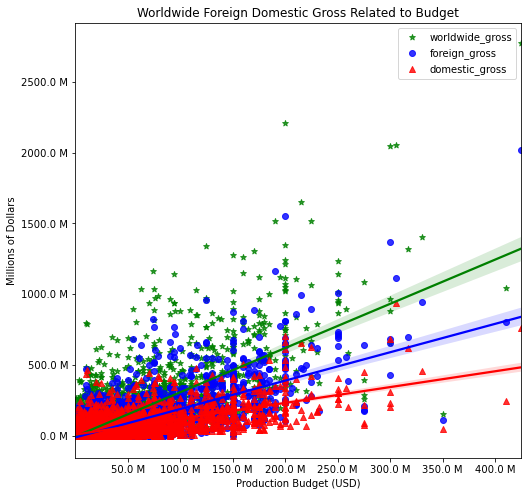

In [295]:
#chart to examine the difference between foreign and domestic gross
    'Worldwide & Domestic Gross Related to Production Budget',
# set up figure convert to millions
def million_formatter(x, pos):
    return "%.1f M" % (x/1E6)
fig, ax = plt.subplots(figsize=(8,8), sharey=True)
# green dots/line will be ww gross as a function of production_budget
ax1 = sns.regplot(data=numbers, x='production_budget',
                 y='worldwide_gross', color='green',marker='*', label='worldwide_gross')
# blue dots/line will be foreign_gross gross as a function of production_budget
ax2 = sns.regplot(data=numbers, x='production_budget',
                 y='foreign_gross', color='blue',marker='o', label='foreign_gross')
# red dots/line will be domestic_gross as a function of production_budget
ax2 = sns.regplot(data=numbers, x='production_budget',
                 y='domestic_gross', color='red',marker='^', label='domestic_gross')
# include a legend
ax.legend()
# set title and axis labels
ax.set(title='Worldwide Foreign Domestic Gross Related to Budget',
      xlabel='Production Budget (USD)',
      ylabel = 'Millions of Dollars')
ax.xaxis.set_major_formatter(million_formatter)
ax.yaxis.set_major_formatter(million_formatter)

In [299]:
#created a list to establish the single genres
gs = []
genlist = huey['genres'].str.split(',')

for things in genlist:
    gs.extend(things)
ugs = set(gs)
ugs

list(ugs)

['Adventure',
 'Family',
 'Crime',
 'Fantasy',
 'Mystery',
 'Musical',
 'History',
 'Western',
 'Action',
 'News',
 'Romance',
 'Comedy',
 'Drama',
 'Thriller',
 'Horror',
 'Sport',
 'Documentary',
 'Animation',
 'Music',
 'Reality-TV',
 'Sci-Fi',
 'War',
 'Biography']

### creating scatter plot to analyze runtime vs WWgross for each genre

In [307]:
def generun(gene):
    jon = huey.loc[huey['genres'].str.contains(gene)]
    fig, ax = plt.subplots(figsize=(10,10))
    x = jon['runtime_minutes']
    y = jon['worldwide_gross']
    plt.ticklabel_format(style='plain')
    ax.scatter(x,y)
    ax.axvline(x.mean(), label='Median', linestyle='--', color= 'Red')
    ax.set_xlabel('runtime in minutes')
    ax.set_ylabel('worldwide_gross')
    ax.set_title(print(f'Runtime vs. WorldWide Gross for {gene}'));

# Genre Data Exploration 

Runtime vs. WorldWide Gross for Adventure


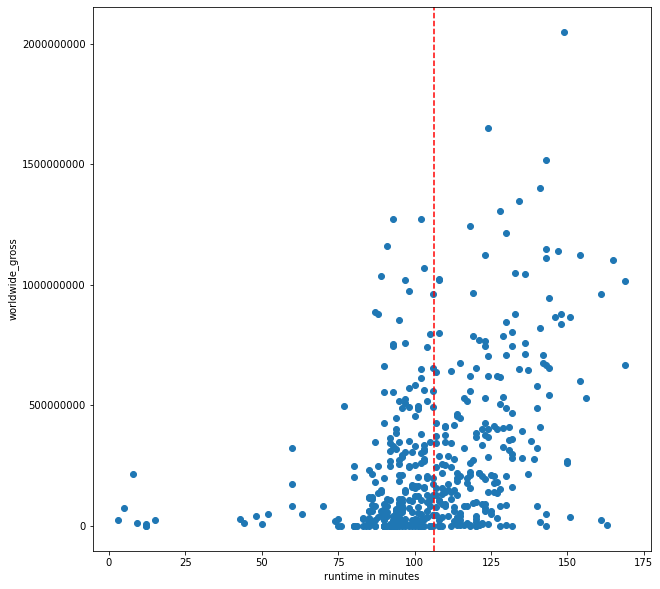

In [308]:
generun('Adventure')

Runtime vs. WorldWide Gross for Animation


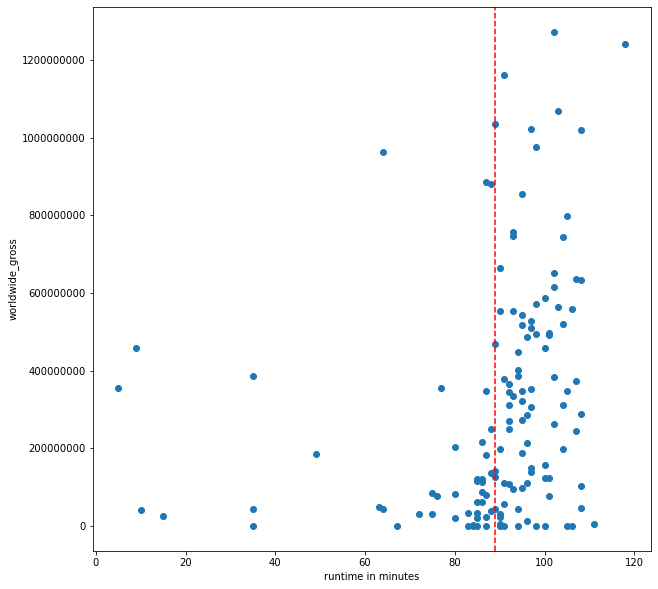

In [309]:
generun('Animation')

Runtime vs. WorldWide Gross for Fantasy


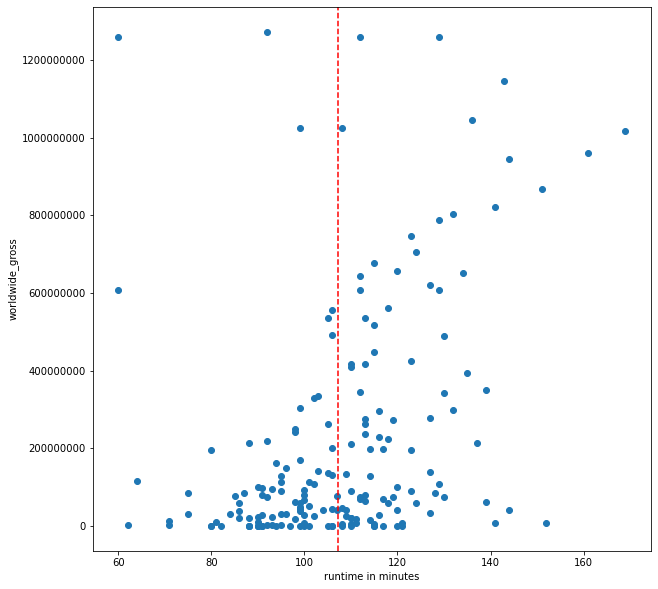

In [310]:
generun('Fantasy')

Runtime vs. WorldWide Gross for Action


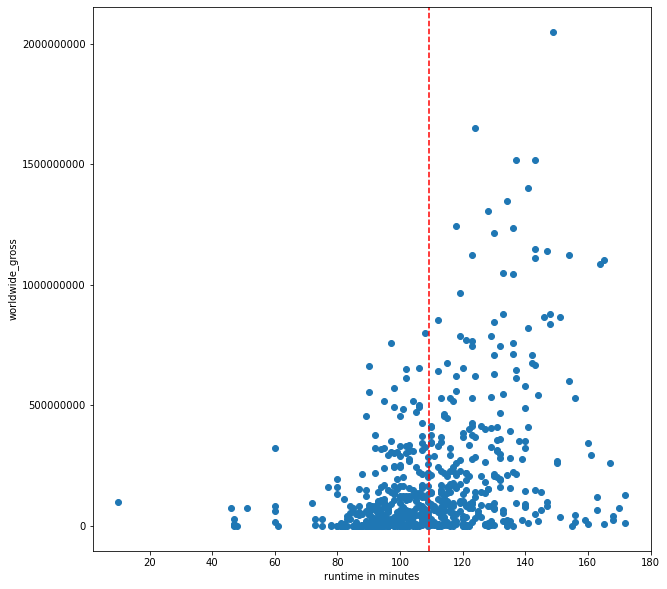

In [311]:

generun('Action')

Runtime vs. WorldWide Gross for Sci-Fi


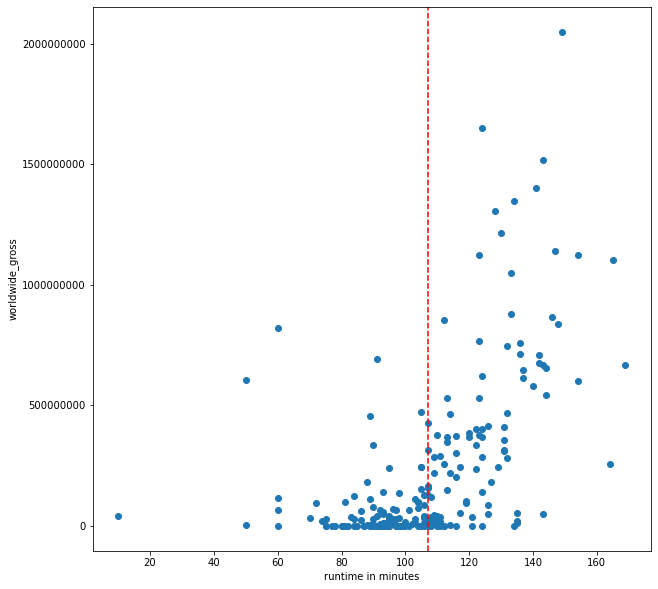

In [312]:
generun('Sci-Fi')

### setting variable to sort by ROI for the graph

In [ ]:
hueyroi = huey.sort_values(by='ROI', ascending=False)[50:]

In [ ]:
hueyroi

### DOING GRAPHS OF BUDGET TO ROI BY GENRE

In [289]:
#
def genebudget(gene):
    top_sort = hueyroi.sort_values(by=['ROI'], ascending=False)[1:]
    jon = top_sort.loc[top_sort['genres'].str.contains(gene)]
    fig, ax = plt.subplots(figsize=(10,10))
    y = jon['ROI']
    x = jon['production_budget']
    ax.scatter(x,y)
    plt.ticklabel_format(style='plain')
    ax.set_yticks([100, 500, 1000, 2000, 3000])
    ax.set_xticks([10000000, 70000000, 150000000, 250000000])
    ax.axvline(x.median(), label='Median', linestyle='--', color= 'Red')
    ax.set_ylabel('ROI by percentage')
    ax.set_xlabel('production budget 10MM - 250MM')
    ax.set_title(print(f'budget - ROI comaprison for {gene}'))
    

budget - ROI comaprison for Adventure


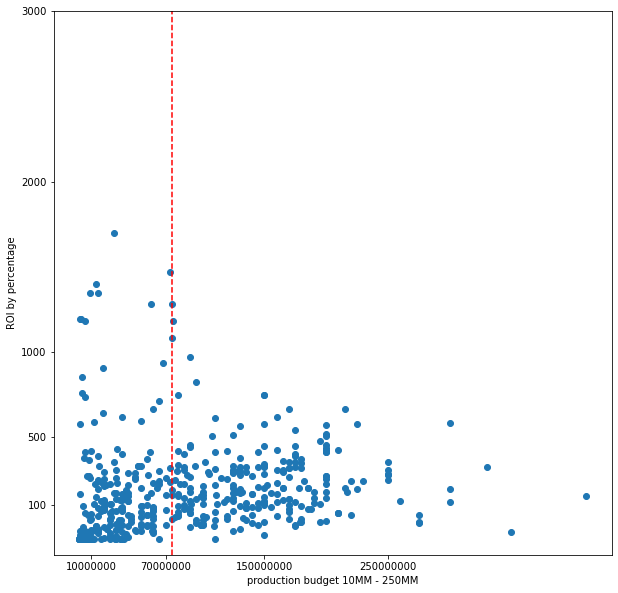

In [290]:
genebudget('Adventure')

budget - ROI comaprison for Animation


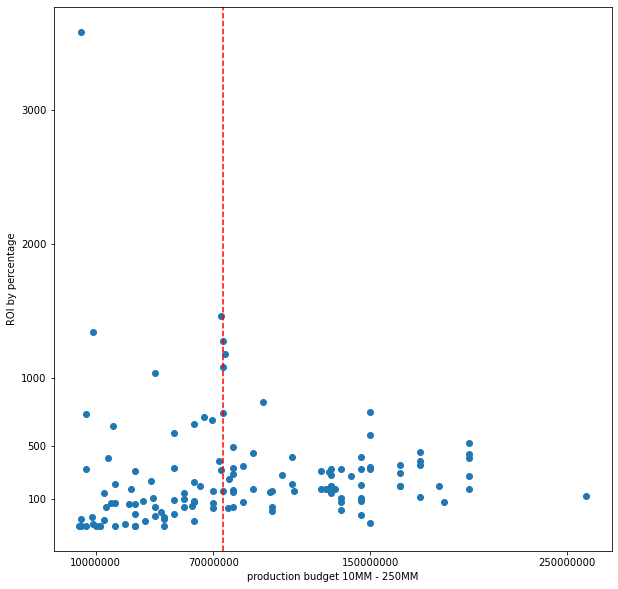

In [291]:
genebudget('Animation')

budget - ROI comaprison for Fantasy


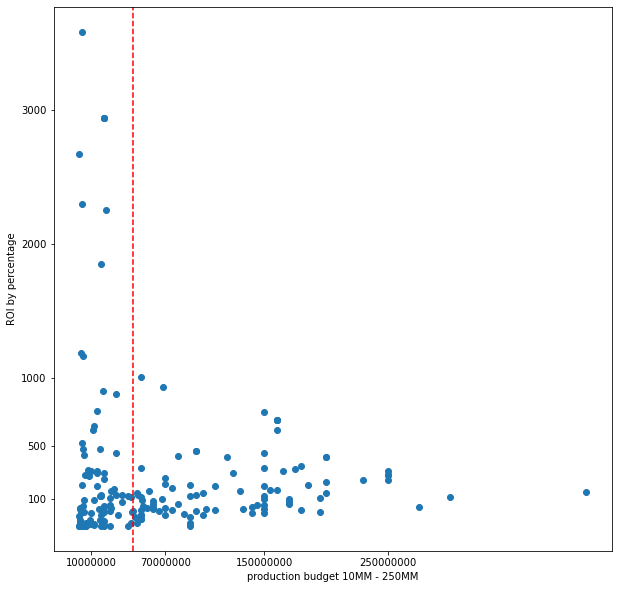

In [292]:
genebudget('Fantasy')

budget - ROI comaprison for Action


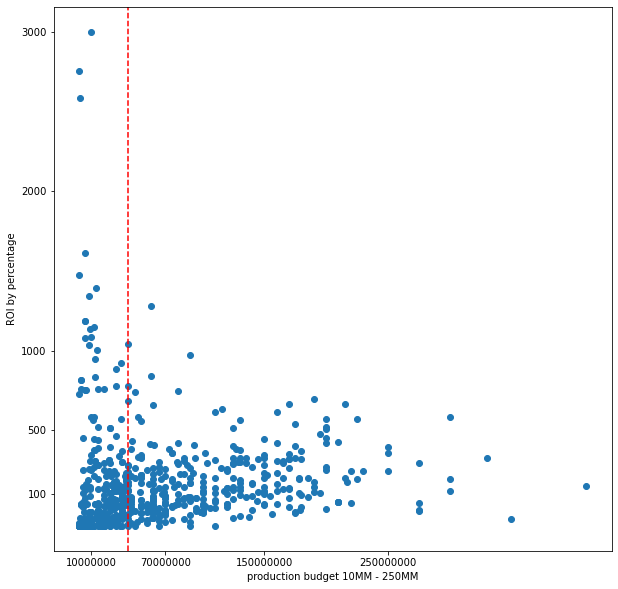

In [293]:

genebudget('Action')

budget - ROI comaprison for Sci-Fi


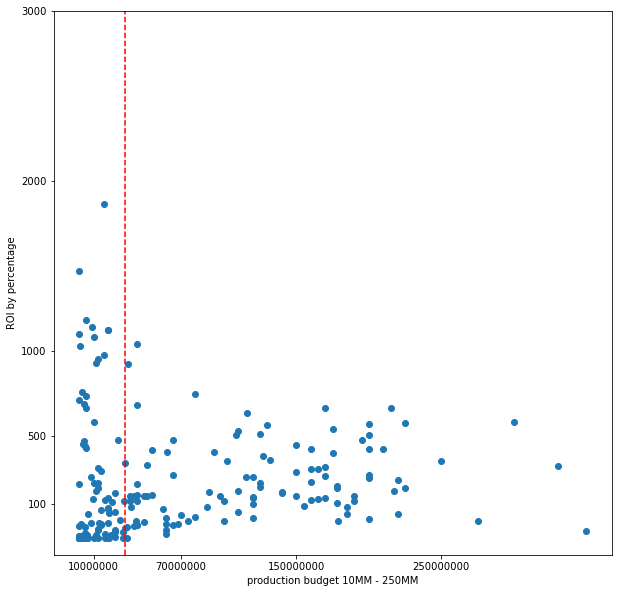

In [294]:
genebudget('Sci-Fi')

In [ ]:
huey.loc[huey['ROI'] > 20000]

In [ ]:
genebudget('Romance')

In [186]:
#individual code for merging tables, expliding for individual genres

In [78]:
run_time = pd.read_sql("""
select *
from movie_basics
""", conn)

In [79]:
run_time['genres_list'] = run_time['genres'].str.split(',')

In [80]:
single_genres = run_time.explode('genres_list')

In [81]:
num_genre_join = numbers.merge(single_genres, left_on='movie', right_on='primary_title')

In [253]:
#createing a variable to get the mean of the world wide gross for each genre
num_genre_group_mean_WWG = num_genre_join.groupby('genres_list')['worldwide_gross'].median()

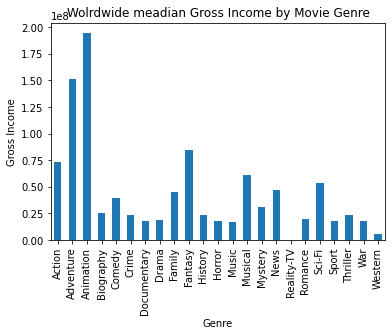

In [255]:
#table to demonstrate the top genres by wwgross median
num_genre_group_mean_WWG.plot(kind='bar', title ='Wolrdwide meadian Gross Income by Movie Genre', ylabel='Gross Income', xlabel='Genre');

In [256]:
#sorting values of mean worldwide gross grouped by genre
num_genre_group_mean_WWG.sort_values(ascending=False).head(6)

genres_list
Animation    194503502.0
Adventure    150977672.0
Fantasy       84227013.0
Action        73249137.5
Musical       61031932.0
Sci-Fi        53424681.0
Name: worldwide_gross, dtype: float64

NameError: name 'jon' is not defined

In [ ]:
# Market selection on Genres

In [171]:
# created a variable to calculate te domestic gross medians listed by genre
jupe_dom = num_genre_join.groupby('genres_list')['domestic_gross'].median()

In [172]:
#created a list variable for the top five foreign gross medians
top_5_dmeds = [jupe_dom['Action'], jupe_dom['Adventure'], jupe_dom['Fantasy'], jupe_dom['Sci-Fi'], jupe_dom['Animation']]

In [175]:
#created varibable for top 5 foreign medians in the same order as domestic
top_5_fmeds = [jupe_for['Action'], jupe_for['Adventure'], jupe_for['Fantasy'], jupe_for['Sci-Fi'], jupe_for['Animation']]

In [176]:
#created a variable to align the top five foriegn gross medians for our char. We also put the in the same order as the list of top 5 domestic
top_5_fmeds

[34657447.0, 85523894.0, 42367409.5, 21503654.0, 104810579.0]

In [160]:
#created a variable to get the median forigen gross for each genre
jupe_for = num_genre_join.groupby('genres_list')['foreign_gross'].median()

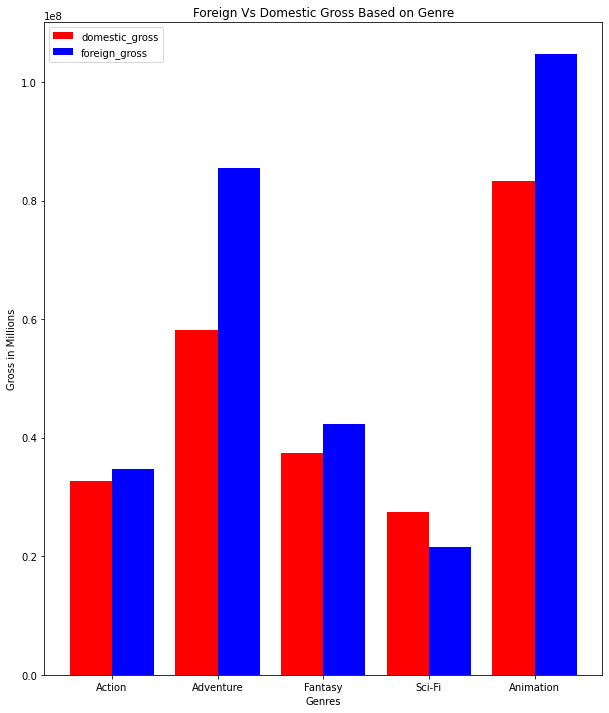

In [185]:
#created a bar chart that shows the difference  between each genres foreign and domestic gross
x = ['Action', 'Adventure', 'Fantasy', 'Sci-Fi', 'Animation']
x_axis = np.arange(len(x))
plt.figure(figsize=(10,12))
plt.bar(x_axis - .2, top_5_dmeds, color ='red',
        width = 0.4, label = 'domestic_gross' )
plt.bar(x_axis + .2, top_5_fmeds, color ='blue',
        width = 0.4, label = 'foreign_gross' )
plt.xlabel("Genres")
plt.ylabel("Gross in Millions")
plt.title("Foreign Vs Domestic Gross Based on Genre")
plt.xticks(x_axis,x)
plt.legend()
plt.show();